In [1]:
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')

import seaborn as sns
from ionpy.analysis import ResultsLoader
from ese.experiment.experiment.ese_exp import CalibrationExperiment
sns.set_style("darkgrid")

import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))

# Results loader object does everything
rs = ResultsLoader()
root = "/storage/vbutoi/scratch/ESE/"

%load_ext yamlmagic
%load_ext autoreload
%autoreload 2

In [2]:
train_path = f"{root}/training/10_23_23_Dense_WMH"

dfc = rs.load_configs(
    train_path,
    properties=False,
)

  0%|          | 0/4 [00:00<?, ?it/s]

In [3]:
# Set the device
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

best_exp = rs.get_best_experiment(
    df=rs.load_metrics(dfc),
    exp_class=CalibrationExperiment,
    device="cuda"
)

  0%|          | 0/2 [00:00<?, ?it/s]

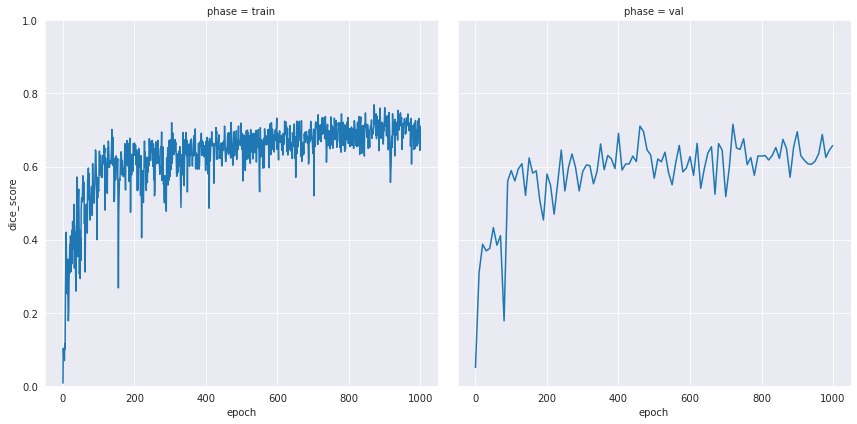

In [4]:
best_exp.vis_loss_curves(height=6)

In [5]:
from ese.experiment.analysis.inference import load_cal_inference_stats

inference_path = f"{root}/inference/11_10_23_WMH_SUME"

cal_inference_info = load_cal_inference_stats(
    log_dir=inference_path,
)

In [6]:
cal_inference_info.keys()

dict_keys(['pixel_info_dicts', 'image_info_df', 'metadata'])

In [7]:
metadata = cal_inference_info['metadata']

In [8]:
metadata['log_set'].iloc[0]

'20231110_222002-IBNP-5e156d766d8e5cd7eccfb8ee7af825aa'

In [9]:
cal_inference_info["pixel_info_dicts"].keys()

dict_keys(['20231110_222002-IBNP-5e156d766d8e5cd7eccfb8ee7af825aa', '20231110_222002-7EEQ-6fdf656d6be78700135426381a11c3aa', '20231110_222002-7ASL-a5574d203829fd9375e4a840e2158777'])

In [10]:
# Get the pixel preds out
pixel_preds_dict = cal_inference_info["pixel_info_dicts"][metadata['log_set'].iloc[0]]

## Pixel-level Analysis

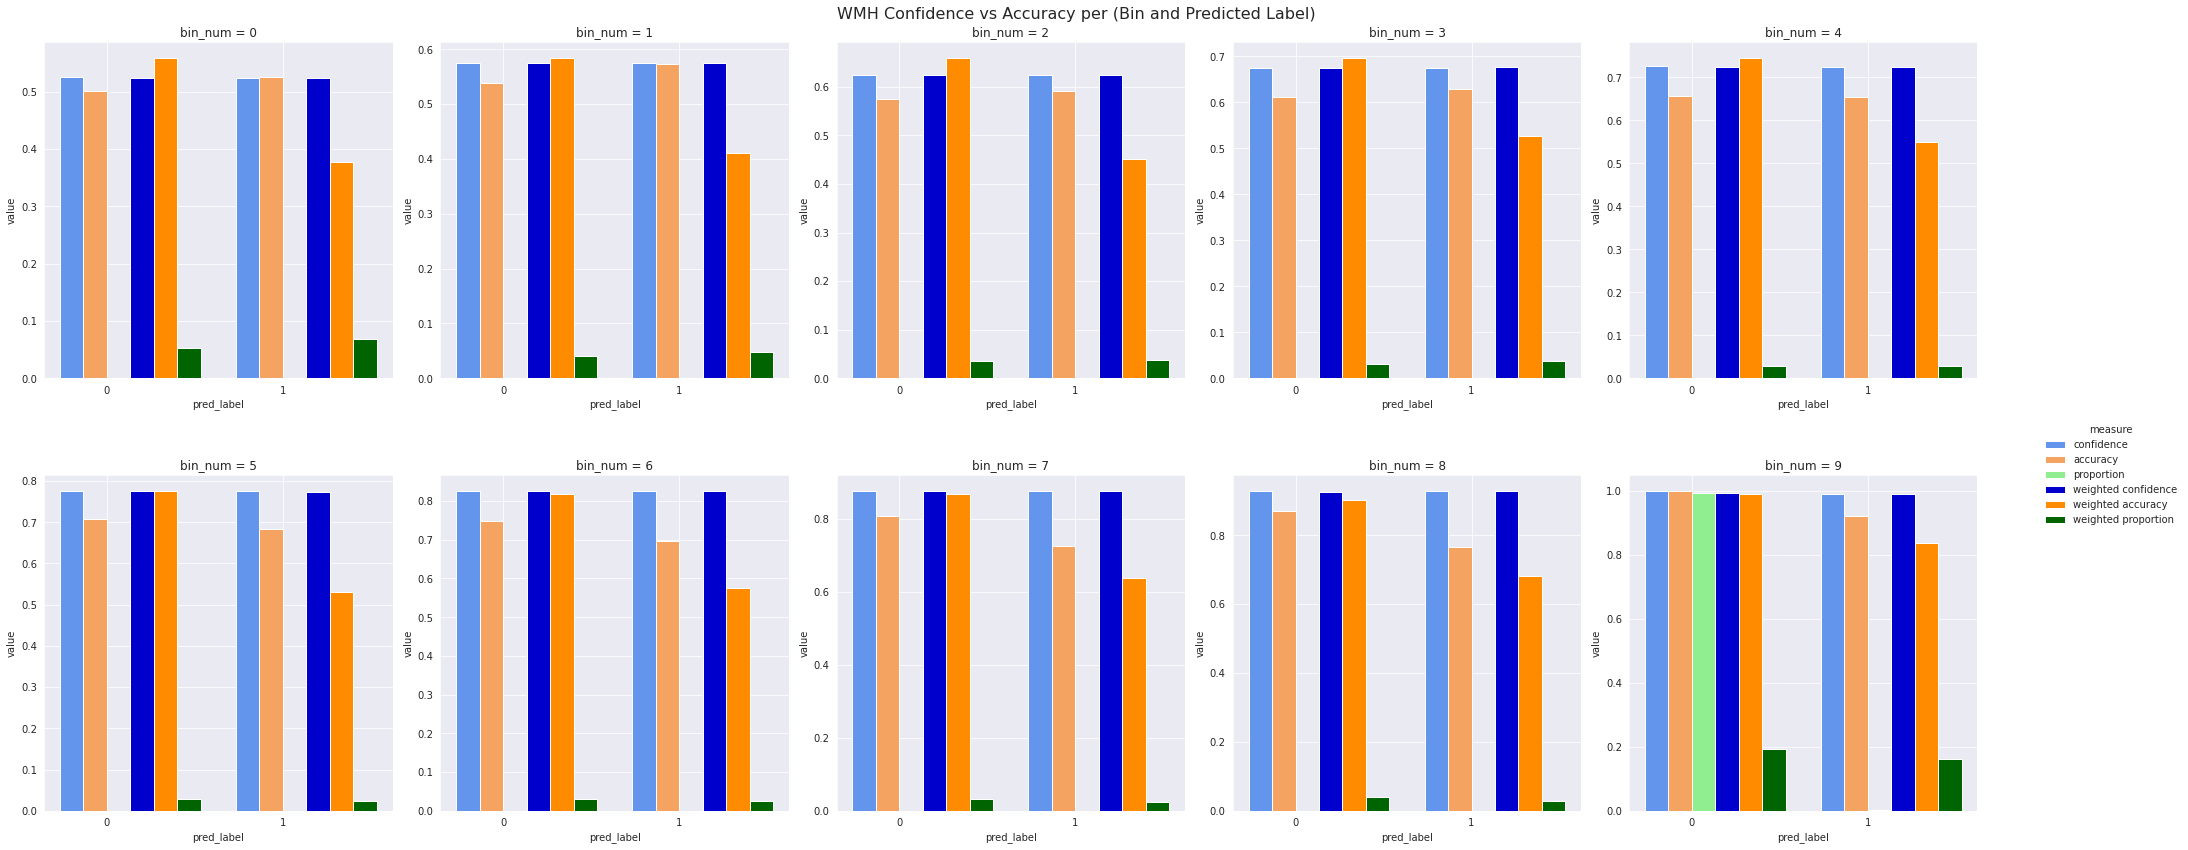

In [11]:
from ese.experiment.analysis.err_diagrams import viz_accuracy_vs_confidence

viz_accuracy_vs_confidence(
    pixel_preds_dict,
    title="WMH Confidence vs Accuracy per (Bin and Predicted Label)",
    x="pred_label",
    col="bin_num",
    kind="bar",
    add_avg=False,
    facet_kws={'sharey': False, 'sharex': False}
    )

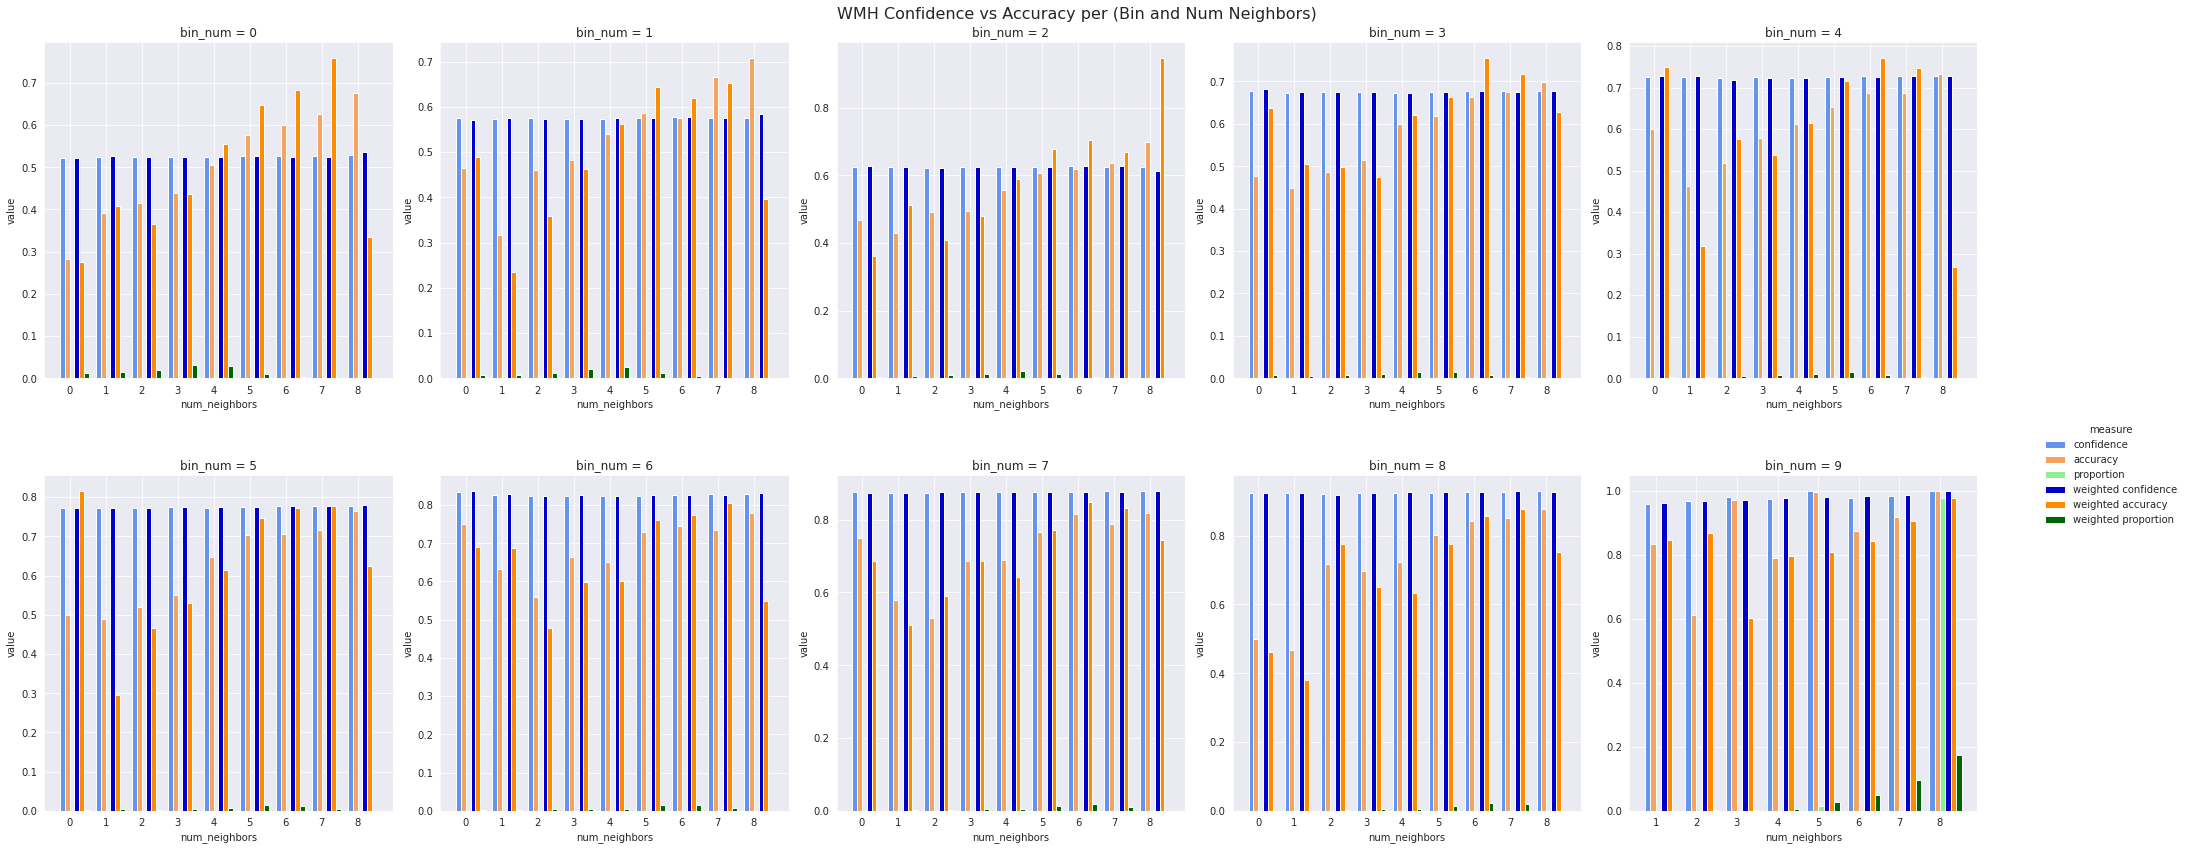

In [12]:
from ese.experiment.analysis.err_diagrams import viz_accuracy_vs_confidence

viz_accuracy_vs_confidence(
    pixel_preds_dict,
    title="WMH Confidence vs Accuracy per (Bin and Num Neighbors)",
    x="num_neighbors",
    col="bin_num",
    kind="bar",
    add_avg=False,
    add_proportion=True,
    facet_kws={'sharey': False, 'sharex': False},
    )

## Image-level Analysis

In [13]:
image_info_df = cal_inference_info['image_info_df']

In [14]:
image_info_df.head()

,accuracy,bin_weighting,cal_metric,cal_score,data_id,dice,w_accuracy,slice_idx,annotator,axis,num_slices,preload,slicing,task,version,split,_class,log_set
0,0.999939,proportional,ECE,0.000039,103,2.500000e-08,0.5,0,observer_o12,0,1,False,dense_full,Amsterdam,0.2,cal,ese.experiment.datasets.WMH,20231110_222002-IBNP-5e156d766d8e5cd7eccfb8ee7...
1,0.999939,uniform,ECE,0.000004,103,2.500000e-08,0.5,0,observer_o12,0,1,False,dense_full,Amsterdam,0.2,cal,ese.experiment.datasets.WMH,20231110_222002-IBNP-5e156d766d8e5cd7eccfb8ee7...
2,0.999939,proportional,TL_ECE,0.000039,103,2.500000e-08,0.5,0,observer_o12,0,1,False,dense_full,Amsterdam,0.2,cal,ese.experiment.datasets.WMH,20231110_222002-IBNP-5e156d766d8e5cd7eccfb8ee7...
3,0.999939,uniform,TL_ECE,0.000004,103,2.500000e-08,0.5,0,observer_o12,0,1,False,dense_full,Amsterdam,0.2,cal,ese.experiment.datasets.WMH,20231110_222002-IBNP-5e156d766d8e5cd7eccfb8ee7...
4,0.999939,proportional,CW_ECE,0.000039,103,2.500000e-08,0.5,0,observer_o12,0,1,False,dense_full,Amsterdam,0.2,cal,ese.experiment.datasets.WMH,20231110_222002-IBNP-5e156d766d8e5cd7eccfb8ee7...


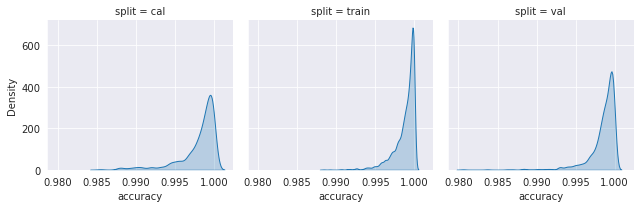

In [15]:
# Now using seaborn's FacetGrid to create the KDE plots for the 'accuracy' column for each 'split'.
g = sns.FacetGrid(image_info_df, col="split", col_wrap=3, sharex=True, sharey=True)
g = g.map(sns.kdeplot, "accuracy", fill=True)

# Adjusting the layout
g.fig.tight_layout()

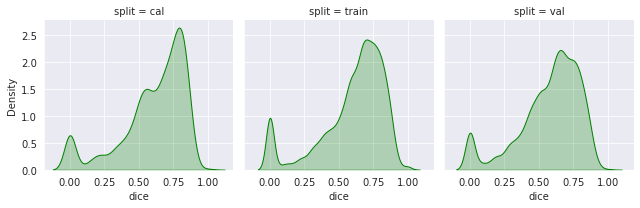

In [16]:
# Now using seaborn's FacetGrid to create the KDE plots for the 'accuracy' column for each 'split'.
g = sns.FacetGrid(image_info_df, col="split", col_wrap=3, sharex=True, sharey=True)
g = g.map(sns.kdeplot, "dice", fill=True, color="green")

# Adjusting the layout
g.fig.tight_layout()

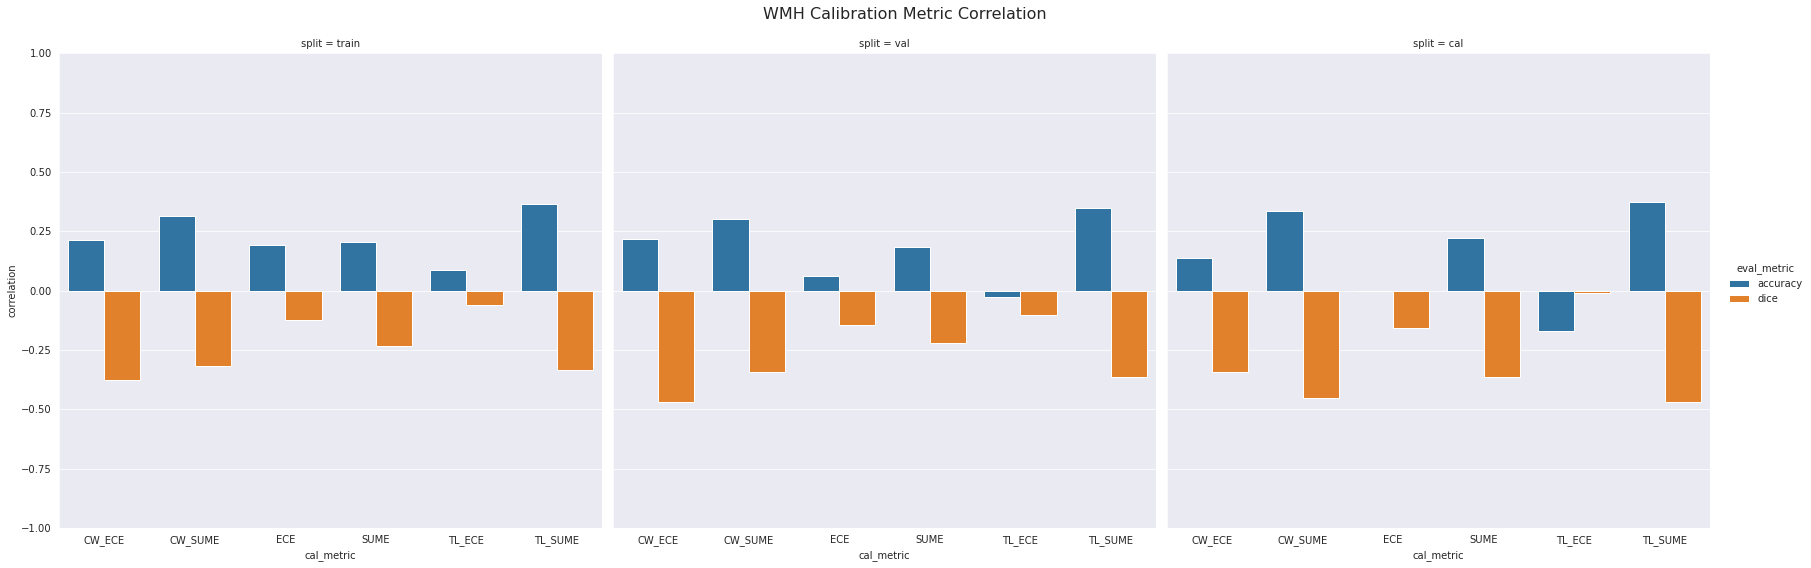

In [20]:
from ese.experiment.analysis.err_diagrams import viz_cal_metric_corr

viz_cal_metric_corr(
    image_info_df,
    title="WMH Calibration Metric Correlation",
    x="cal_metric",
    hue="eval_metric",
    col="split",
    )